# Textures

In [246]:
import os
import warnings
import numpy as np
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from scipy import fft
from scipy.signal import find_peaks
from scipy.ndimage import binary_dilation
import cv2
from skimage.exposure import rescale_intensity

from skimage import (
    io, color, morphology, filters, transform, data
)
from skimage.color import rgb2gray, label2rgb
from skimage.filters.rank import entropy
from skimage.feature import graycoprops, graycomatrix
from skimage.segmentation import find_boundaries, mark_boundaries
from skimage.transform import probabilistic_hough_line
from skimage.draw import line as skimage_line
from skimage.measure import label
from skimage.morphology import remove_small_objects, disk
import warnings
from felzenszwalb_segmentation import segment
from skimage.morphology import disk
from skimage.filters import rank
from skimage.segmentation import felzenszwalb as segment
import cv2

from skimage.morphology import disk
from skimage.filters.rank import mean as rank_mean
from skimage import morphology
from skimage.segmentation import felzenszwalb as segment

plt.rc({'family': 'normal', 'weight': 'normal'})
plt.rcParams['font.size'] = 18
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning, module='skimage')


## MAIN ALGORITHM

### Function for loading images

In [247]:
def load_images_from_folder(folder_path):

    images = []
    # Получаем список всех файлов в папке
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.png'):  # Или другой формат, если нужно
            img = plt.imread(file_path)  # Загружаем изображение как объект Image
            images.append(img)  # Добавляем в список
    
    return images


### Function for Felzenszwalb Segmentation

In [248]:
def felz_segm(im_contrast):
    # Преобразуем изображение в RGB (повторяя данные канала)
    im_contrast1 = np.stack([im_contrast]*3, axis=-1)  # Создаем 3 канала из одного изображения

    print(im_contrast1.shape)

    segmented_image = segment(im_contrast1, 0.2, 400, 50)
    print(segmented_image.shape)
    print(segmented_image.astype(np.uint8).shape)


    return segmented_image.astype(np.uint8)


In [249]:


def segment_it(img):
    # Препроцессинг
    img = (img * 255).astype(np.uint8)
    kern = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8, 8))
    img1 = kern.apply(img)
    blurred_img = cv2.GaussianBlur(img1, (11, 11), 0)

    sElem = disk(20)
    pageFloat = blurred_img
    pageFilt = rank_mean(pageFloat, footprint=sElem) / 255
    img_processed = pageFloat - pageFilt
    img_denoised1 = cv2.medianBlur(np.uint8(img_processed), 7)

    # Вторичная обработка
    img2 = (img_denoised1 * 255).astype(np.uint8)

    img_entropy = entropy(img2, morphology.disk(10))

    # Сегментация
    im_contrast = np.stack([img] * 3, axis=-2)  # Конвертируем в 3-канальное изображение
    segmented_image = segment(im_contrast, 0.2, 400, 50)

    return segmented_image.astype(np.uint8)


### Function for saving images

In [250]:
def save_images_to_folder(textures, output_folder):
    # Создаём папку, если она не существует
    os.makedirs(output_folder, exist_ok=True)
    
    # Сохраняем каждое изображение в папку
    for idx, texture in enumerate(textures):
        # Преобразуем массив NumPy в изображение PIL
        img = Image.fromarray((texture * 255).astype(np.uint8))  # Преобразование в 8-битное изображение
        image_name = f'seg_{idx + 1}_1_1.png'  # Придумываем имя для каждого изображения
        image_path = os.path.join(output_folder, image_name)
        img.save(image_path)  # Сохраняем изображение
        print(f"Изображение сохранено: {image_path}")


### Algo function

In [251]:
def main_alg(data_folder_path, output_folder_path):

    #Loading images
    images = load_images_from_folder(data_folder_path)
    #list for output
    textures = [] 
    
    # Plot for visualisation
    fig, axes = plt.subplots(len(images), 1, figsize=(10, 15 * len(images)))
    
    # 
    if len(images) == 1:
        axes = [axes]

    #MAIN ALGO
    for idx, (image, ax) in enumerate(zip(images, axes)):
        
        texture = felz_segm(image)
        textures.append(texture)

        # visualisation
        ax.imshow(textures, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Filtered Texture {idx + 1}")
    
    # Сохраняем текстуры в папку
    save_images_to_folder(textures, output_folder_path)
    

    
    # Отображаем все изображения
    plt.tight_layout()
    plt.show()

## Calling algo!

(512, 512, 3)
(512, 512)
(512, 512)


TypeError: Invalid shape (1, 512, 512) for image data

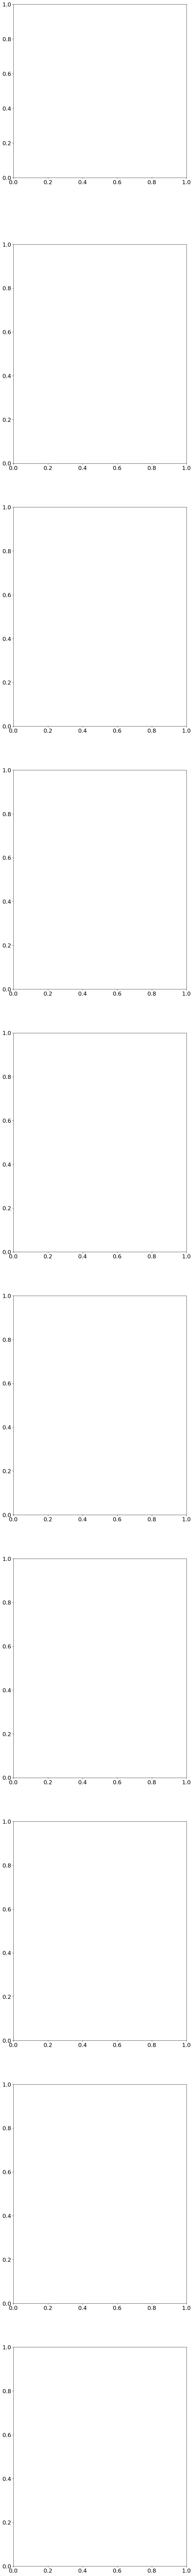

In [252]:
if __name__ == "__main__":
    data_folder_path = '/home/ilyarekun/17.ComputerVision25/texture_assignment/data'
    output_folder_path = 'output'
    #check_folder(data_folder_path)
    main_alg(data_folder_path, output_folder_path)

